This notebook focuses on trying to find a way to segment cells within organoids properly.
The end goals is to segment cell and extract morphology features from cellprofiler.
These masks must be imported into cellprofiler to extract features.

## import libraries 

In [1]:
import argparse
import multiprocessing
import pathlib
from multiprocessing import Pool

import matplotlib.pyplot as plt

# Import dependencies
import numpy as np
import tifffile
from skimage import io

# check if in a jupyter notebook
try:
    cfg = get_ipython().config
    in_notebook = True
except NameError:
    in_notebook = False

## parse args and set paths

In [2]:
if not in_notebook:
    print("Running as script")
    # set up arg parser
    parser = argparse.ArgumentParser(description="Segment the nuclei of a tiff image")

    parser.add_argument(
        "--input_dir",
        type=str,
        help="Path to the input directory containing the tiff images",
    )
    parser.add_argument(
        "--compartment",
        type=str,
        default="none",
        help="Compartment to segment. Options are 'nuclei', 'cell',",
    )

    args = parser.parse_args()
    input_dir = pathlib.Path(args.input_dir).resolve(strict=True)
    compartment = args.compartment
else:
    print("Running in a notebook")
    input_dir = pathlib.Path("../examples/raw_z_input/").resolve(strict=True)
    compartment = "nuclei"

mask_path = pathlib.Path(f"../processed_data/{input_dir.stem}").resolve()
mask_path.mkdir(exist_ok=True, parents=True)

if compartment == "nuclei":
    mask_file_path = pathlib.Path(mask_path / "nuclei_masks.tiff").resolve()
    reconstruction_dict_path = pathlib.Path(
        mask_path / "nuclei_reconstruction_dict.npy"
    ).resolve(strict=True)
elif compartment == "cell":
    mask_file_path = pathlib.Path(mask_path / "cell_masks.tiff").resolve()
    reconstruction_dict_path = pathlib.Path(
        mask_path / "cell_reconstruction_dict.npy"
    ).resolve(strict=True)
else:
    raise ValueError("Invalid compartment, please choose 'nuclei' or 'cell'")

Running in a notebook


## Set up images, paths and functions

In [3]:
class DecoupleSlidingWindowMasks:
    def __init__(self, lambda_IOU_threshold: int = 0.8, image_stack: np.array = None):
        self.lambda_IOU_threshold = lambda_IOU_threshold
        self.image_stack = image_stack
        self.mask_indices_dict = {
            "unique_mask": [],
            "mask_indices": [],
            "psuedo_slice": [],
        }
        self.overlap_dict = {"unique_mask": [], "mask_indices": [], "psuedo_slice": []}

    def get_unique_masks(self):

        # find each unqiue mask identity via pixel value
        unique_masks = np.unique(self.image_stack)
        # loop through each unique mask identity
        for unique_mask in unique_masks:
            # loop through each mask image
            for psuedo_slice in range(len(self.image_stack)):
                # find where the unique mask identity is in the mask image
                tmp_image = self.image_stack[psuedo_slice]
                mask_indices = np.where(tmp_image == unique_mask)
                # if the mask identity is in the mask image
                self.mask_indices_dict["unique_mask"].append(unique_mask)
                self.mask_indices_dict["mask_indices"].append(mask_indices)
                self.mask_indices_dict["psuedo_slice"].append(psuedo_slice)

    def check_overlap(self):
        # check for which masks overlap with each other across psuedo slices
        for mask_index, mask_indices in enumerate(
            self.mask_indices_dict["mask_indices"]
        ):
            for mask_index_2, mask_indices_2 in enumerate(
                self.mask_indices_dict["mask_indices"]
            ):
                if mask_index != mask_index_2:
                    # set some variables pertaining to the masks
                    unique_mask_num = self.mask_indices_dict["unique_mask"][mask_index]
                    unique_mask_num_2 = self.mask_indices_dict["unique_mask"][
                        mask_index_2
                    ]
                    psuedo_slice = self.mask_indices_dict["psuedo_slice"][mask_index]
                    psuedo_slice_2 = self.mask_indices_dict["psuedo_slice"][
                        mask_index_2
                    ]
                    # check if the masks overlap
                    intersection = np.intersect1d(mask_indices, mask_indices_2)
                    union = np.union1d(mask_indices, mask_indices_2)
                    try:
                        IOU = len(intersection) / len(union)
                    except ZeroDivisionError:
                        continue
                    IOU = len(intersection) / len(union)
                    if IOU > self.lambda_IOU_threshold:
                        # keep the larger mask
                        mask_area = sum([len(x) for x in mask_indices])
                        mask_area_2 = sum([len(x) for x in mask_indices_2])
                        if mask_area > mask_area_2:
                            self.overlap_dict["unique_mask"].append(unique_mask_num)
                            self.overlap_dict["mask_indices"].append(mask_indices)
                            self.overlap_dict["psuedo_slice"].append(psuedo_slice)
                        elif mask_area < mask_area_2:
                            self.overlap_dict["unique_mask"].append(unique_mask_num_2)
                            self.overlap_dict["mask_indices"].append(mask_indices_2)
                            self.overlap_dict["psuedo_slice"].append(psuedo_slice_2)
                        else:
                            print("Mask areas are equal, picking the first mask")
                            self.overlap_dict["unique_mask"].append(unique_mask_num)
                            self.overlap_dict["mask_indices"].append(mask_indices)
                            self.overlap_dict["psuedo_slice"].append(psuedo_slice)

    def reconstruct_image(self):
        new_image = np.zeros(self.image_stack[0].shape)
        # replace the overlapping masks with the new mask and its identity
        for mask_index, mask_indices in enumerate(self.overlap_dict["mask_indices"]):
            # replace pixel values with unique mask identity at the mask indices
            new_image[mask_indices] = self.overlap_dict["unique_mask"][mask_index]
        return new_image

    def decouple_masks(self):
        self.get_unique_masks()
        self.check_overlap()
        return self.reconstruct_image()

In [4]:
image_extensions = {".tif", ".tiff"}
files = sorted(input_dir.glob("*"))
files = [str(x) for x in files if x.suffix in image_extensions]
# get the nuclei image
for f in files:
    if compartment == "nuclei" and "405" in f:
        imgs = io.imread(f)
    elif compartment == "cell" and "555" in f:
        imgs = io.imread(f)
imgs = np.array(imgs)
original_imgs = imgs.copy()
original_z_slice_count = len(imgs)
print("number of z slices in the original image:", original_z_slice_count)

number of z slices in the original image: 35


In [5]:
reconstruction_dict = np.load(reconstruction_dict_path, allow_pickle=True).item()

## Reverse the sliding window max projection

In [6]:
# parallel processing for the cell above


# set the number of cores to use
num_cores = multiprocessing.cpu_count() - 2


def call_mask_decoupling(z_stack_index, z_stack_mask):
    decouple = DecoupleSlidingWindowMasks(
        lambda_IOU_threshold=0.8, image_stack=z_stack_mask
    )
    new_image = decouple.decouple_masks()
    return z_stack_index, new_image


# process each z slice in parallel
with Pool(num_cores) as p:
    results = p.starmap(call_mask_decoupling, reconstruction_dict.items())

# reconstruct the masks into a single image (z-stack)
reconstructed_masks = np.zeros(
    (original_z_slice_count, original_imgs.shape[1], original_imgs.shape[2])
)
for index, new_image in results:
    reconstructed_masks[index] = new_image
# cast the reconstructed masks to int
reconstructed_masks = reconstructed_masks.astype(int)

In [7]:
# # save the masks
print(reconstructed_masks.shape)
print(reconstructed_masks.dtype)
print(reconstructed_masks[0])
# save the masks as tiff
tifffile.imwrite(mask_file_path, reconstructed_masks)

(35, 1537, 1540)
int64
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


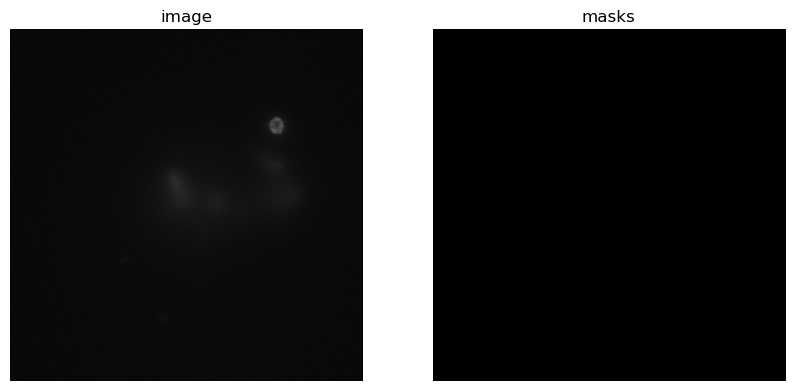

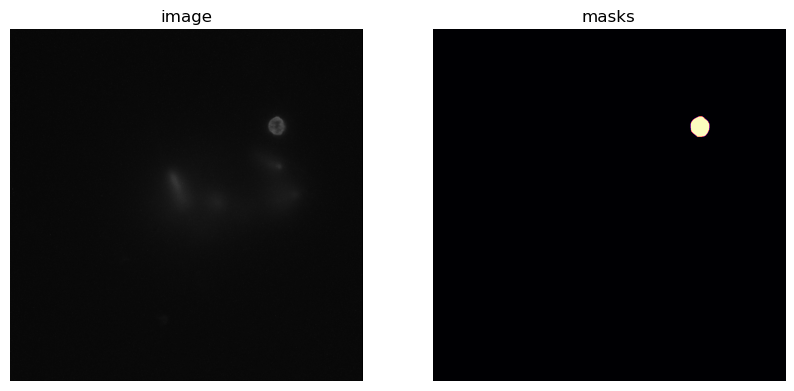

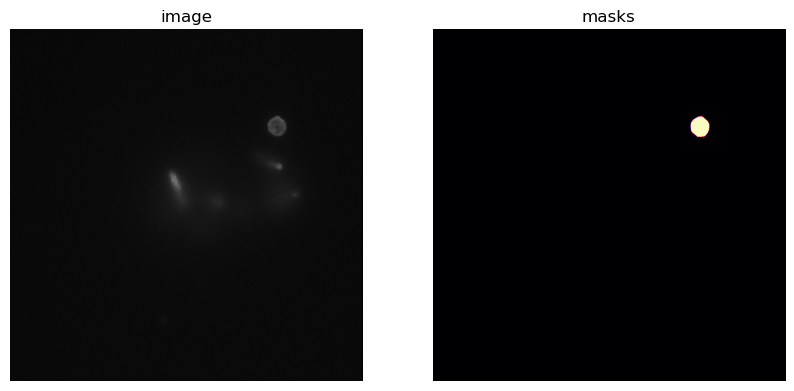

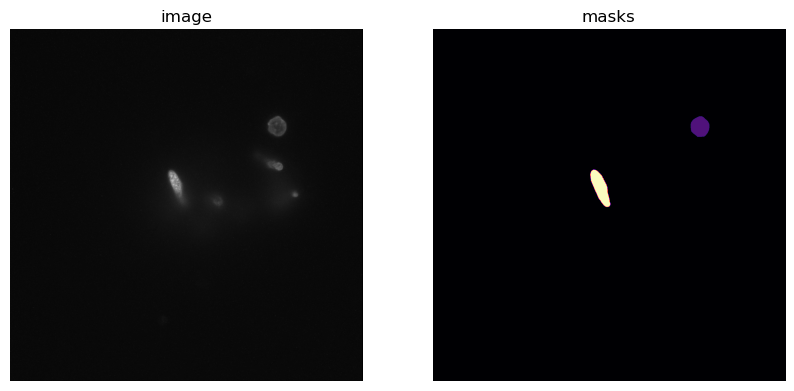

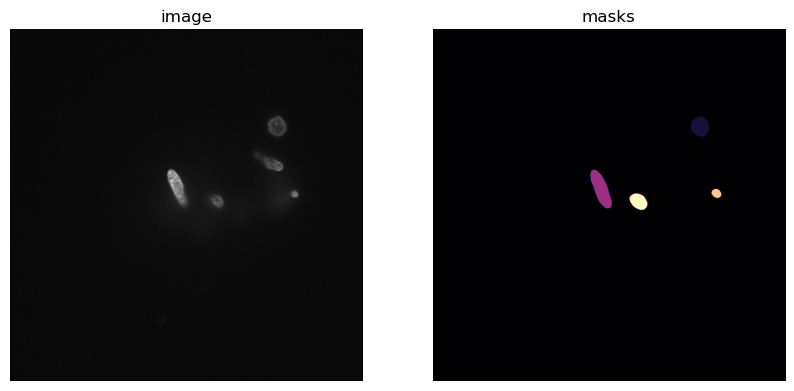

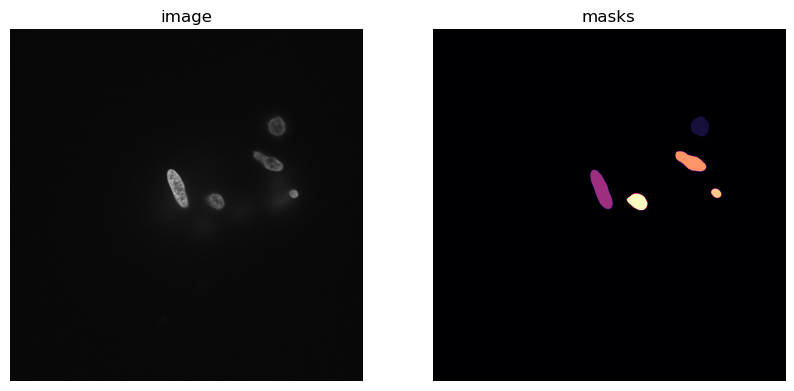

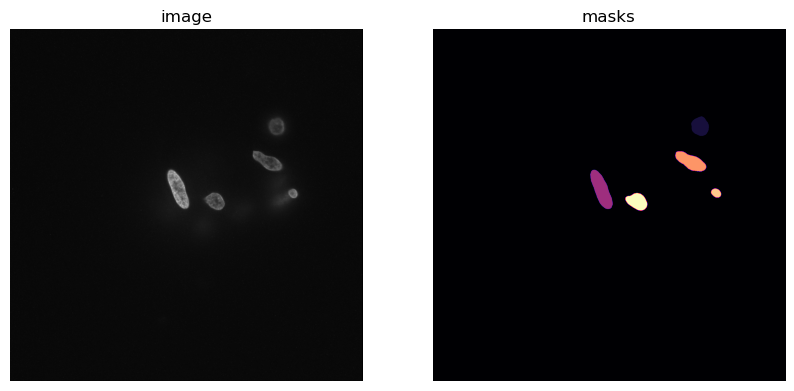

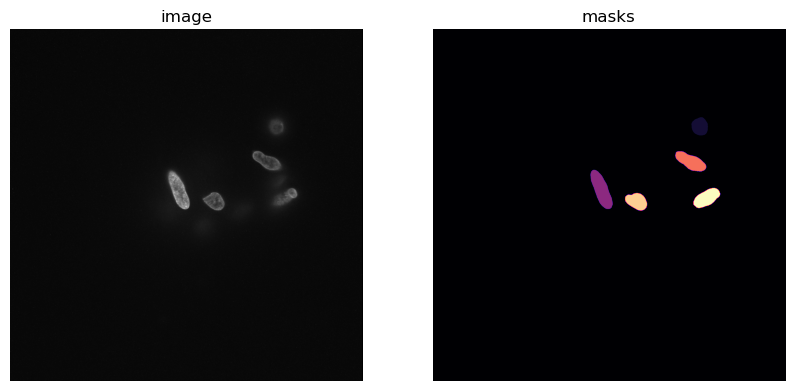

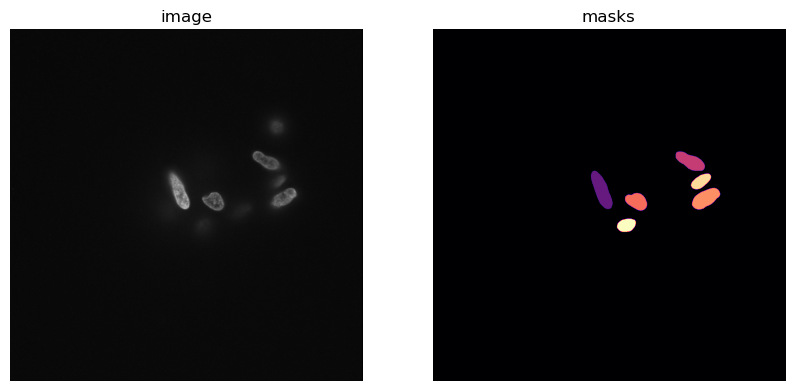

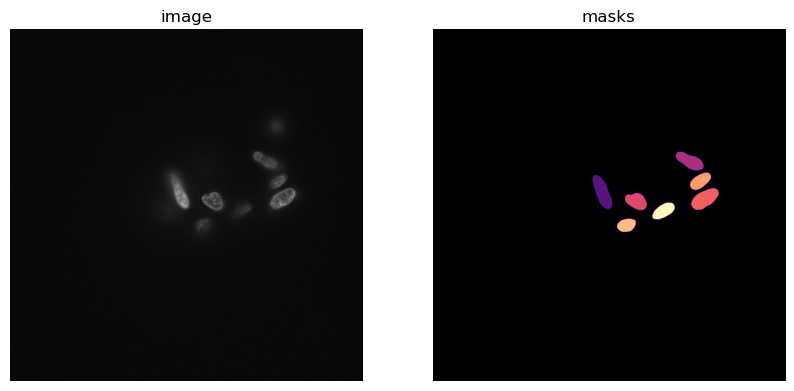

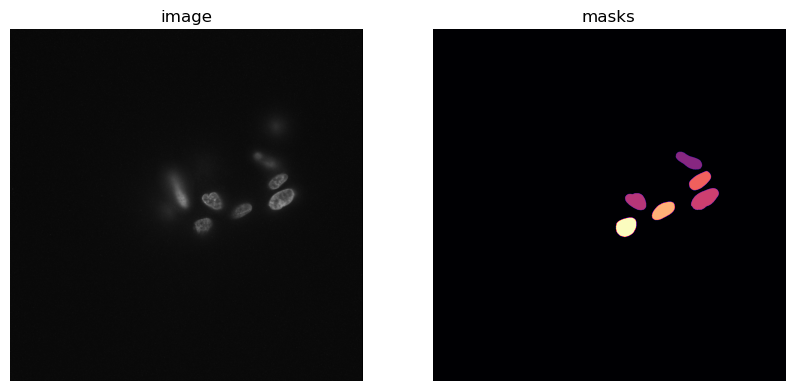

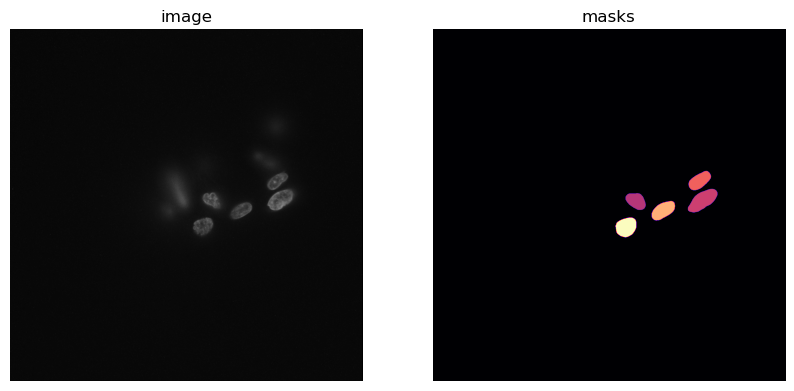

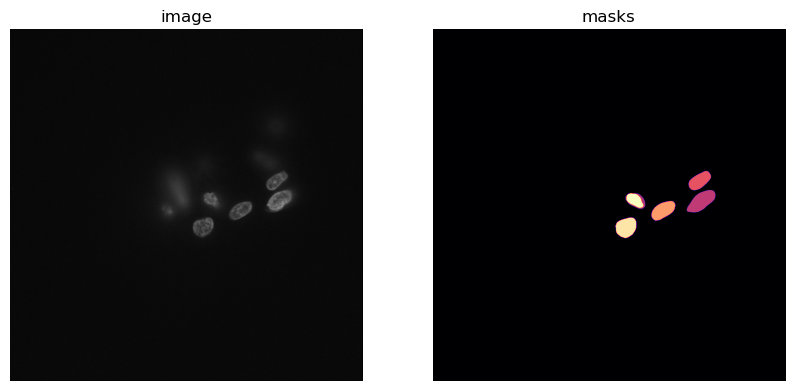

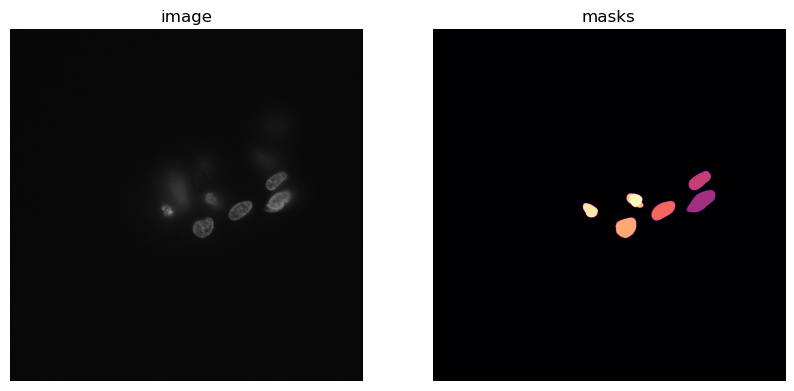

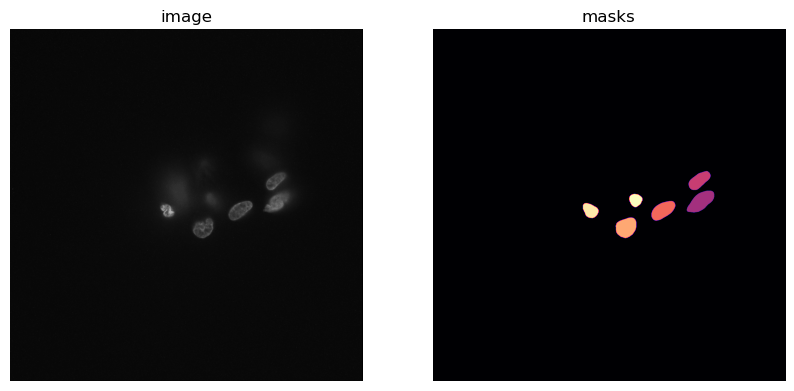

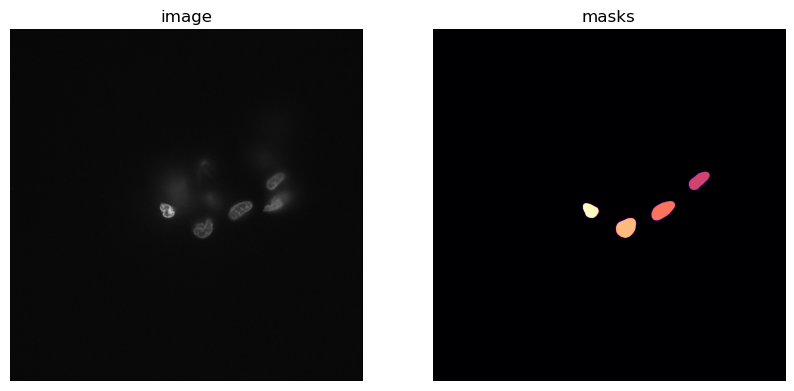

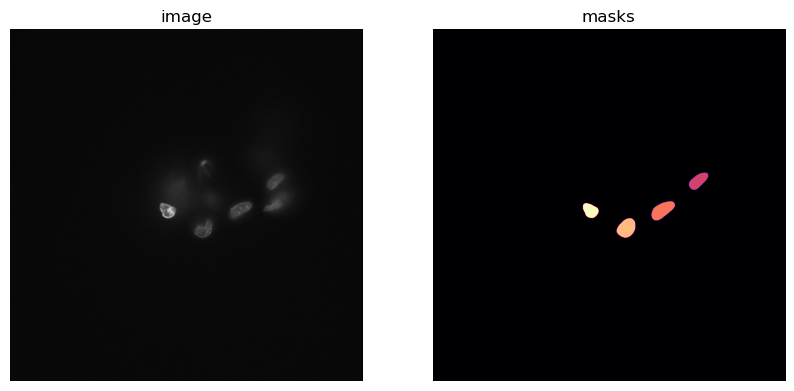

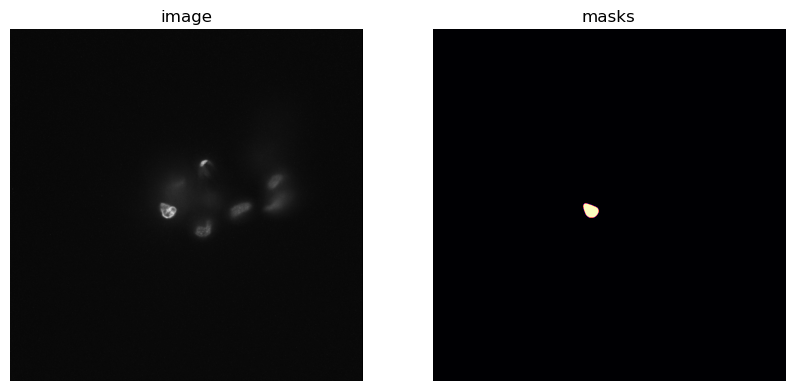

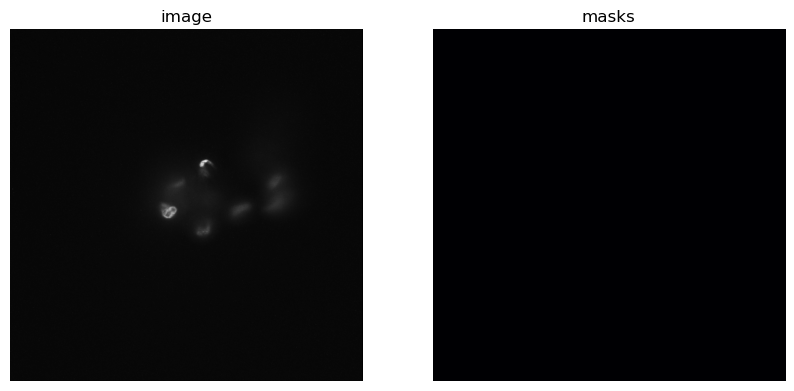

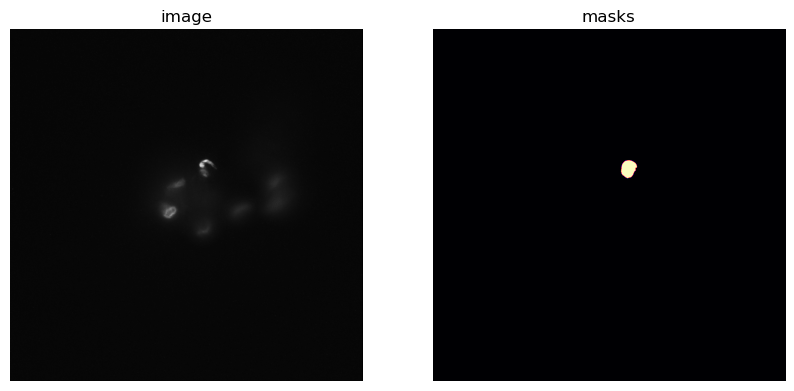

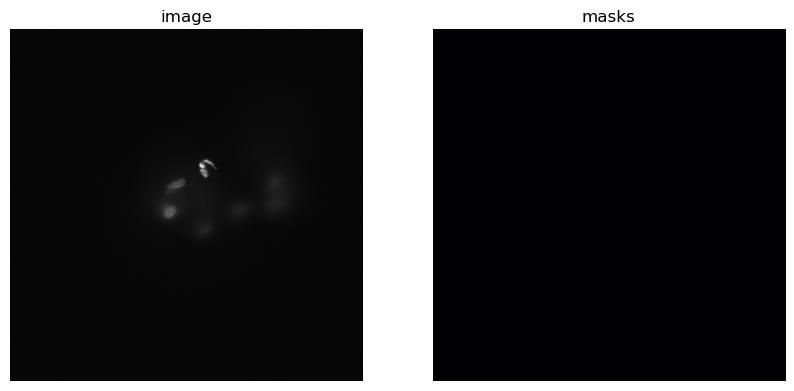

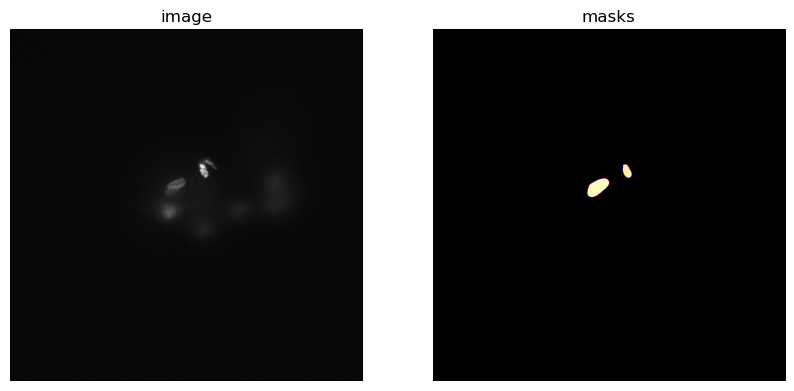

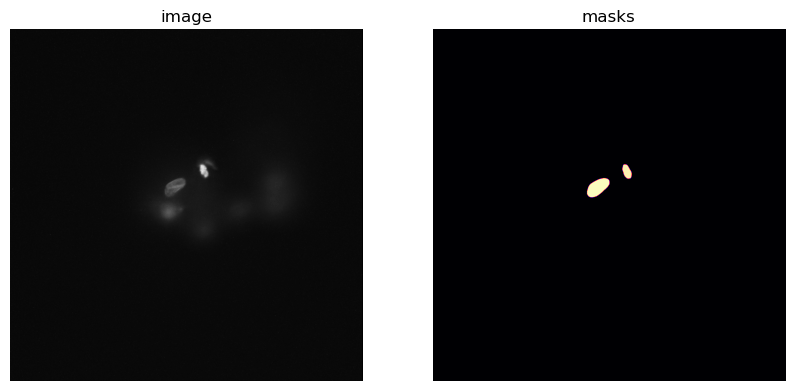

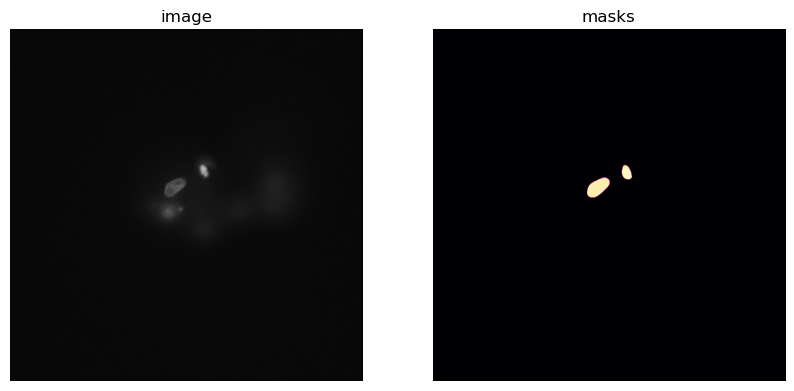

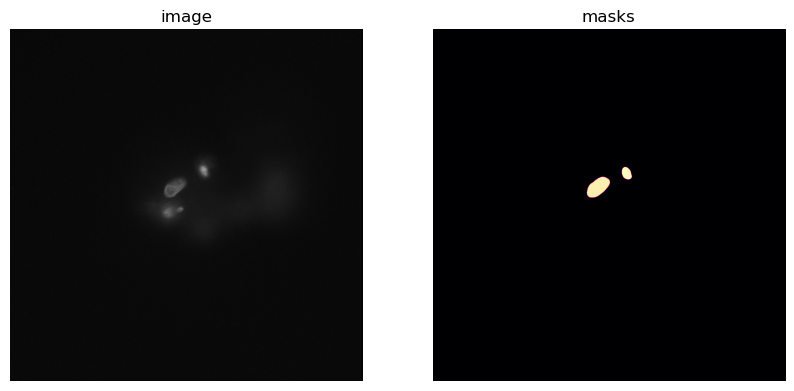

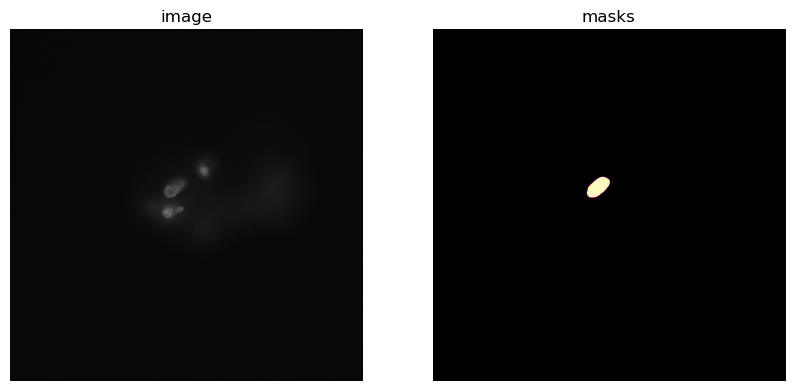

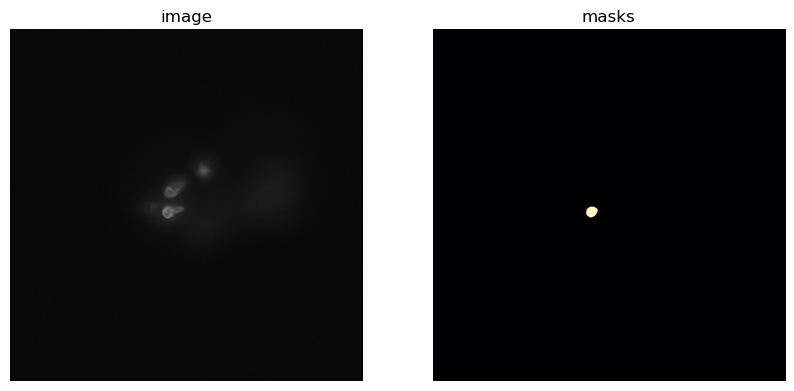

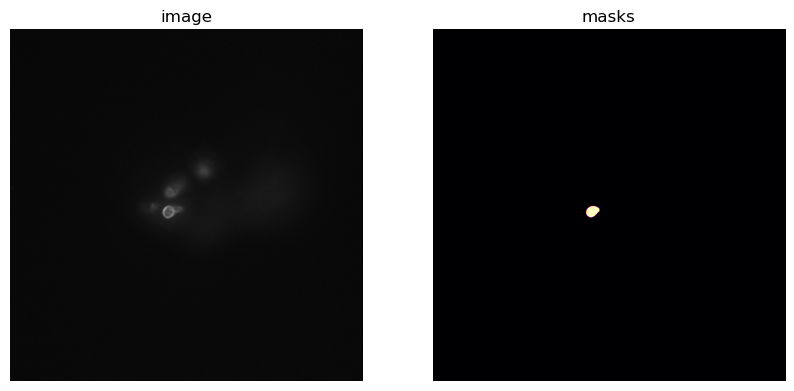

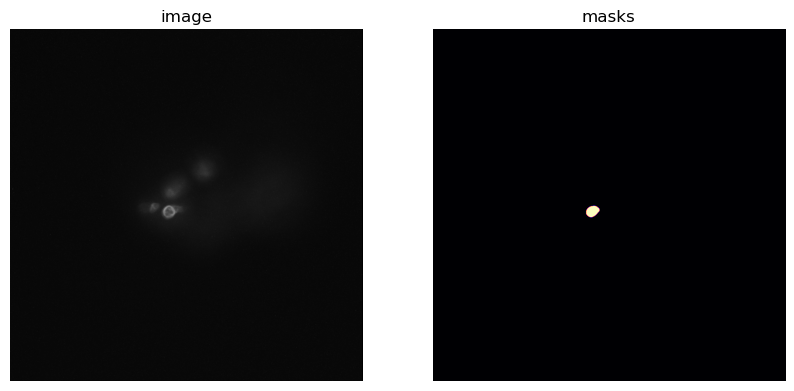

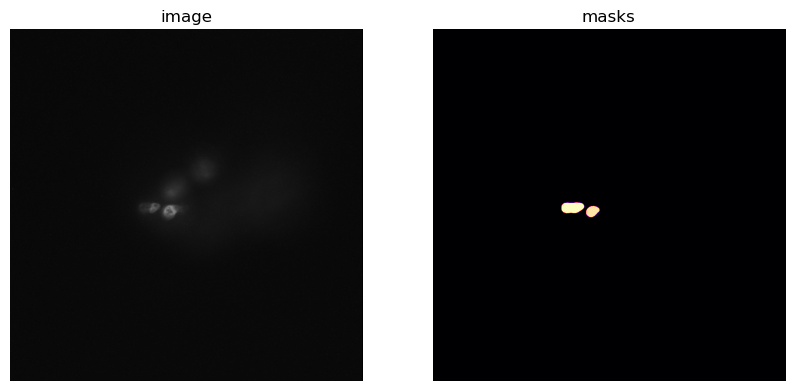

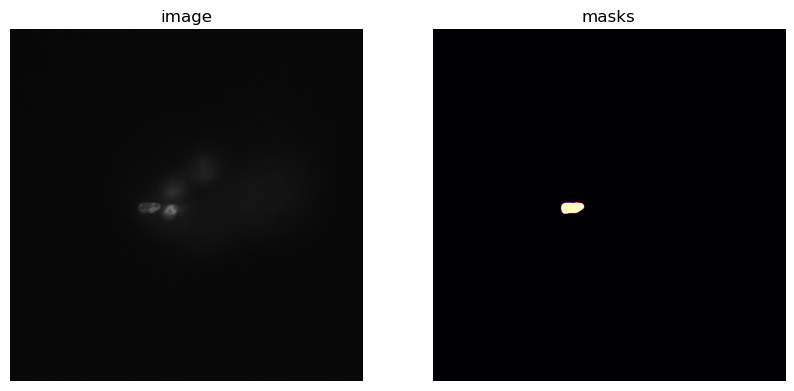

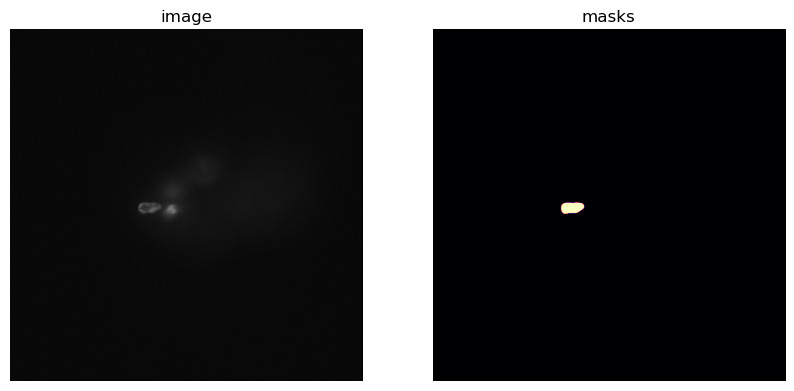

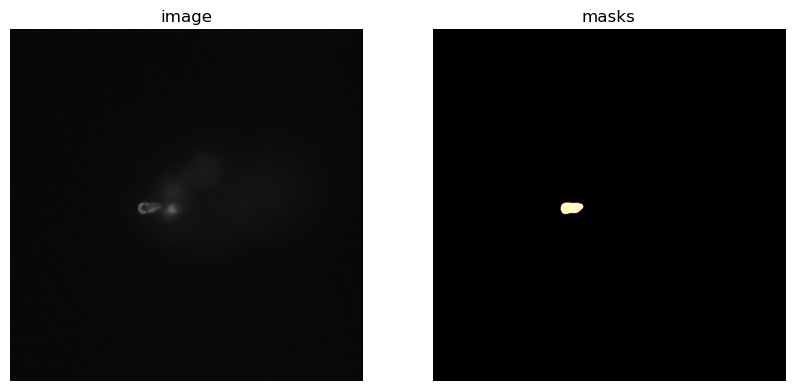

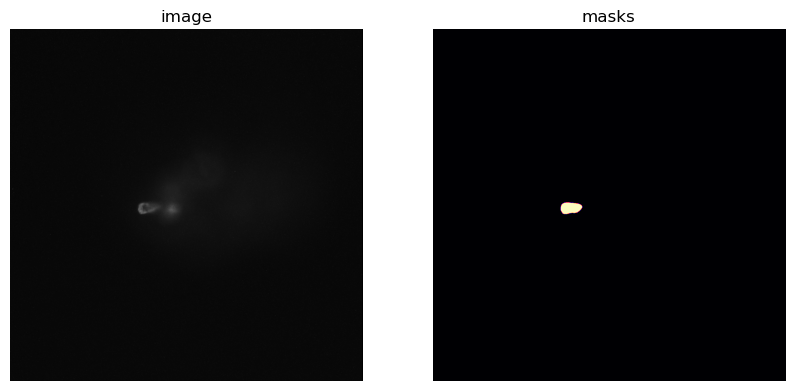

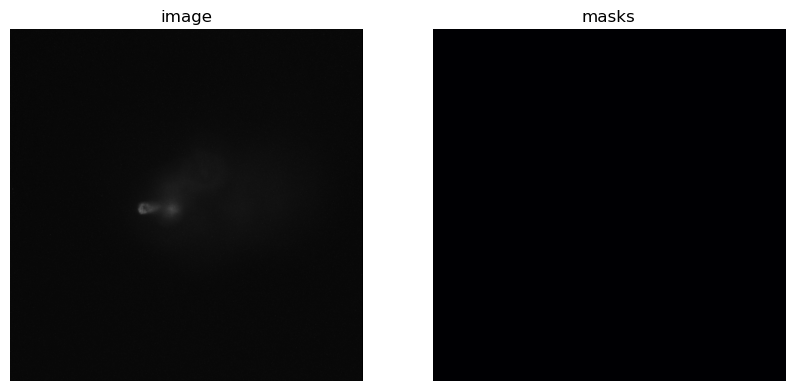

In [8]:
if in_notebook:
    # show each z slice of the image and masks
    for z in range(reconstructed_masks.shape[0]):
        fig = plt.figure(figsize=(10, 5))
        plt.subplot(121)
        plt.imshow(original_imgs[z, :, :], cmap="gray")
        plt.title("image")
        plt.axis("off")
        plt.subplot(122)
        plt.imshow(reconstructed_masks[z], cmap="magma")
        plt.title("masks")
        plt.axis("off")
        plt.show()